In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-tmextwzi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-tmextwzi
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=2b966821243fc27691f6beb2a3c12a70882995ef611e994aff59adfb83732b56
  Stored in directory: /tmp/pip-ephem-wheel-cache-yrimilhf/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import math
from os.path import basename, dirname, join, isfile
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.activation import ReLU
from torchvision import transforms
import cv2
import numpy as np
import clip

In [3]:
class CLIPSegBaseEncoder(nn.Module):

  def __init__(self):
    super().__init__()

    # initialising clip as encoder
    self.clip_model, self.preprocess = clip.load('ViT-B/32', device='cpu', jit=False)
    self.model = self.clip_model.visual

    # freeze the layers of clip
    for p in self.clip_model.parameters():
      p.requires_grad_(False)

    # FiLM layers
    self.film_mulitplier = nn.Linear(512, 128)
    self.film_adder = nn.Linear(512, 128)

    # linear layer for reducing dimensions
    self.reduce = nn.Linear(768, 128)

    # generating prompt variations
    self.prompt_list = ['a photo of a {}.', 'a photograph of a {}.', 'an image of a {}.', '{}.', 'this picture is of a {}']

  # forward pass to get activations
  def visual_forward(self, x_input):
    with torch.no_grad():
      x = self.model.conv1(x_input) 
      x = x.reshape(x.shape[0], x.shape[1], -1)
      x = x.permute(0, 2, 1)
      x = torch.cat([self.model.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)

      # passing through first layer of visual encoder
      x = self.model.ln_pre(x)

      # a forward pass through the layers and obtaining activations
      x = x.permute(1, 0, 2)
      activations = []
      for i, res_block in enumerate(self.model.transformer.resblocks):
        x, aff = self.forward_mha(x, res_block)

        # extracting the information
        if (i == 2 or i == 5 or i == 8):
          activations.append(x)

      x = x.permute(1, 0, 2)
      x = self.model.ln_post(x[:, 0, :])

      # projection
      x = x @ self.model.proj

      return x, activations

  # prompt generator
  def sample_prompts(self, words):
    prompt_indices = torch.multinomial(torch.ones(len(self.prompt_list)), len(words), replacement=True) # random sampling for prompt engineering        
    prompts = [self.prompt_list[i] for i in prompt_indices]
    return [p.format(w) for p, w in zip(prompts, words)]

  # get encoded image and text prompt
  def get_embeddings(self, image, text):
    image_encoded = self.clip_mode.encode_image(image)
    text_encoded = self.clip_model.encode_text(text)
    return (image_encoded, text_encoded)

  # multi head attention, modified to give attention outputs and weights
  def forward_mha(self, x, block):
    tmp_x = block.ln_1(x)
    q, k, v = F.linear(tmp_x, block.attn.in_proj_weight, block.attn.in_proj_bias).chunk(3, dim=-1)
    
    target_length, batch_size, embed_dim = q.size()
    heads = int(embed_dim / block.attn.num_heads)
    scaling_factor = 1 / math.sqrt(embed_dim)

    q = q.contiguous().view(target_length, batch_size * block.attn.num_heads, block.attn.head_dim).transpose(0, 1)
    k = k.contiguous().view(-1, batch_size * block.attn.num_heads, block.attn.head_dim).transpose(0, 1)
    v = v.contiguous().view(-1, batch_size * block.attn.num_heads, block.attn.head_dim).transpose(0, 1)

    q = q * scaling_factor

    attn_output_weights = torch.softmax(torch.bmm(q, k.transpose(1, 2)), dim=-1)
    attn_output = torch.bmm(attn_output_weights, v).transpose(0, 1).contiguous().view(target_length, batch_size, embed_dim)
    attn_output = block.attn.out_proj(attn_output)

    x += block.mlp(block.ln_2(x + attn_output))

    return x, attn_output_weights

In [4]:
class CLIPSeg(CLIPSegBaseEncoder):
  
  def __init__(self):
    super().__init__()
    self.add_activation1 = True
    self.token_shape = (7, 7)
    self.trans_conv_ks = (32, 32)

    self.trans_conv = nn.ConvTranspose2d(128, 1, self.trans_conv_ks, stride=self.trans_conv_ks)

    self.reduces = nn.ModuleList([nn.Linear(768, 128) for _ in range(3)])
    self.blocks = nn.ModuleList([nn.TransformerEncoderLayer(d_model=128, nhead=4) for _ in range(3)])

  def forward(self, input_image):
    input_image = input_image.to(self.model.positional_embedding.device)
    x_input = input_image
    
    batch_sz, device = input_image.shape[0], x_input.device

    visual_query, activations = self.visual_forward(x_input)
    
    tmp = None
    for i, (a, b, r) in enumerate(zip(activations[1:][::-1], self.blocks, self.reduces)):
      if tmp is None : tmp = r(a)
      else: tmp = r(a)+tmp
      
      # if i == 0:
        # cond = self.reduce(cond)
        # tmp = self.film_multiplier(cond) * tmp + self.film_adder(cond)
      
      tmp = b(tmp)

    tmp = tmp[1:].permute(1, 2, 0)
    size = int(math.sqrt(tmp.shape[2]))
    tmp = tmp.view(batch_sz, tmp.shape[1], size, size)

    tmp = self.trans_conv(tmp)

    return tmp, visual_query, [activations[0]] + activations

In [6]:
model = CLIPSeg()
model.eval()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((352, 352)),
])
img_1 = transform(cv2.imread("/content/107900.jpg"))
img = img_1.unsqueeze(0)
prompts = ['a picture of grass', 'an image of zebra', 'pic of hair', 'a photo of legs']

preds = model(img)[0]
preds

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[[[ 0.1288,  0.3465,  0.0980,  ..., -0.2174,  0.4075, -0.1017],
          [ 0.0583,  0.1025, -0.1517,  ...,  0.0401, -0.0200, -0.0403],
          [-0.0386, -0.0158, -0.1168,  ...,  0.2481, -0.1347,  0.0204],
          ...,
          [-0.4754,  0.0299,  0.2080,  ..., -0.0223,  0.1423,  0.3054],
          [-0.1150, -0.3350,  0.5264,  ...,  0.0036, -0.1412,  0.1400],
          [ 0.1088,  0.2987, -0.2237,  ...,  0.0157, -0.0670,  0.2034]]]],
       grad_fn=<ConvolutionBackward0>)

TypeError: ignored

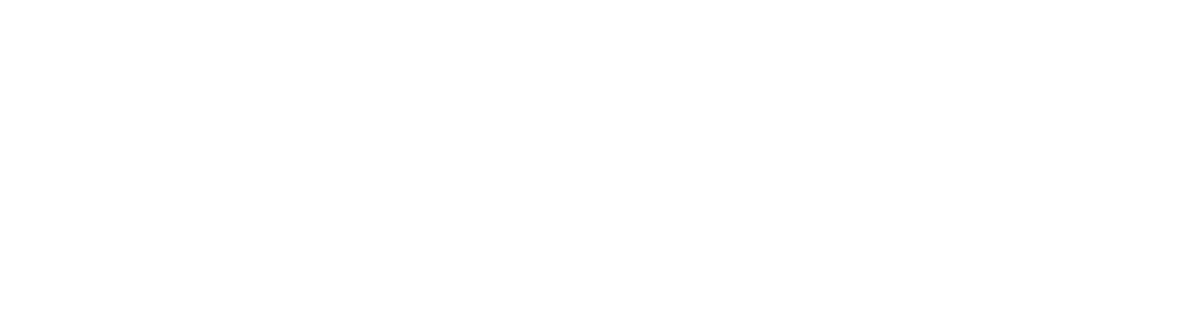

In [7]:
# visualize prediction (fix shape of image)
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(img_1)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(4)];
[ax[i+1].text(0, -15, prompts[i]) for i in range(4)];